#Principal Component Analysis Lab
This lab delves into exploratory analysis of neuroscience data, specifically using principal component analysis (PCA) and feature-based aggregation. We will use a dataset of light-sheet imaging recorded by the Ahrens Lab at Janelia Research Campus, and hosted on the CodeNeuro data repository.

Our dataset is generated by studying the movement of a larval zebrafish, an animal that is especially useful in neuroscience because it is transparent, making it possible to record activity over its entire brain using a technique called light-sheet microscopy. Specifically, we'll work with time-varying images containing patterns of the zebrafish's neural activity as it is presented with a moving visual pattern. Different stimuli induce different patterns across the brain, and we can use exploratory analyses to identify these patterns. Read "Mapping brain activity at scale with cluster computing" for more information about these kinds of analyses.

During this lab you will learn about PCA, and then compare and contrast different exploratory analyses of the same data set to identify which neural patterns they best highlight.

This lab will cover:
Part 1: Work through the steps of PCA on a sample dataset

Visualization 1: Two-dimensional Gaussians
Part 2: Write a PCA function and evaluate PCA on sample datasets

Visualization 2: PCA projection
Visualization 3: Three-dimensional data
Visualization 4: 2D representation of 3D data
Part 3: Parse, inspect, and preprocess neuroscience data then perform PCA

Visualization 5: Pixel intensity
Visualization 6: Normalized data
Visualization 7: Top two components as images
Visualization 8: Top two components as one image
Part 4: Perform feature-based aggregation followed by PCA

Visualization 9: Top two components by time
Visualization 10: Top two components by direction
Note that, for reference, you can look up the details of the relevant Spark methods in Spark's Python API and the relevant NumPy methods in the NumPy Reference

#Part 1: Work through the steps of PCA on a sample dataset
#Visualization 1: Two-dimensional Gaussians
Principal Component Analysis, or PCA, is a strategy for dimensionality reduction. To better understand PCA, we'll work with synthetic data generated by sampling from the two-dimensional Gaussian distribution. This distribution takes as input the mean and variance of each dimension, as well as the covariance between the two dimensions.

In our visualizations below, we will specify the mean of each dimension to be 50 and the variance along each dimension to be 1. We will explore two different values for the covariance: 0 and 0.9. When the covariance is zero, the two dimensions are uncorrelated, and hence the data looks spherical. In contrast, when the covariance is 0.9, the two dimensions are strongly (positively) correlated and thus the data is non-spherical. As we'll see in Parts 1 and 2, the non-spherical data is amenable to dimensionality reduction via PCA, while the spherical data is not.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def prepare_plot(xticks, yticks, figsize=(10.5, 6), hide_labels=False, grid_color='#999999',
                 grid_width=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hide_labels: axis.set_ticklabels([])
    plt.grid(color=grid_color, linewidth=grid_width, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

def create_2D_gaussian(mn, variance, cov, n):
    """Randomly sample points from a two-dimensional Gaussian distribution"""
    np.random.seed(142)
    return np.random.multivariate_normal(np.array([mn, mn]), np.array([[variance, cov], [cov, variance]]), n)

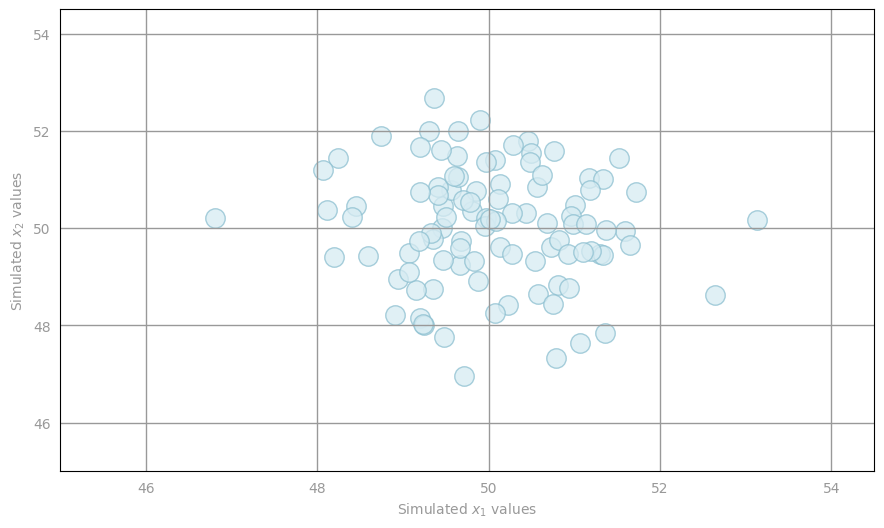

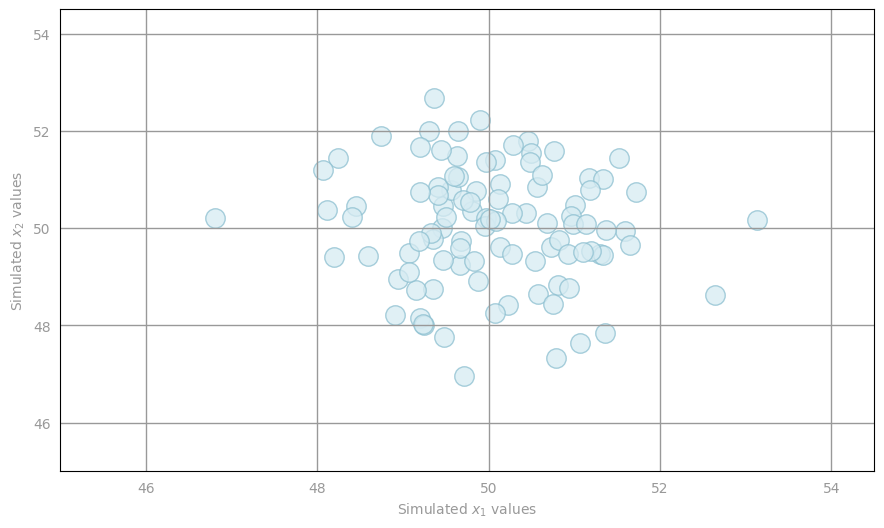

In [3]:
data_random = create_2D_gaussian(mn=50, variance=1, cov=0, n=100)

# generate layout and plot data
fig, ax = prepare_plot(np.arange(46, 55, 2), np.arange(46, 55, 2))
ax.set_xlabel(r'Simulated $x_1$ values'), ax.set_ylabel(r'Simulated $x_2$ values')
ax.set_xlim(45, 54.5), ax.set_ylim(45, 54.5)
plt.scatter(data_random[:,0], data_random[:,1], s=14**2, c='#d6ebf2', edgecolors='#8cbfd0', alpha=0.75)
display(fig)

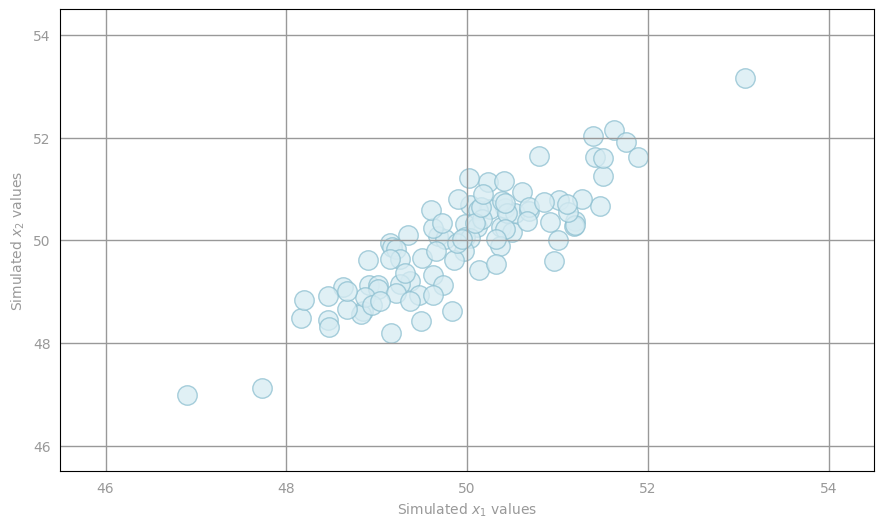

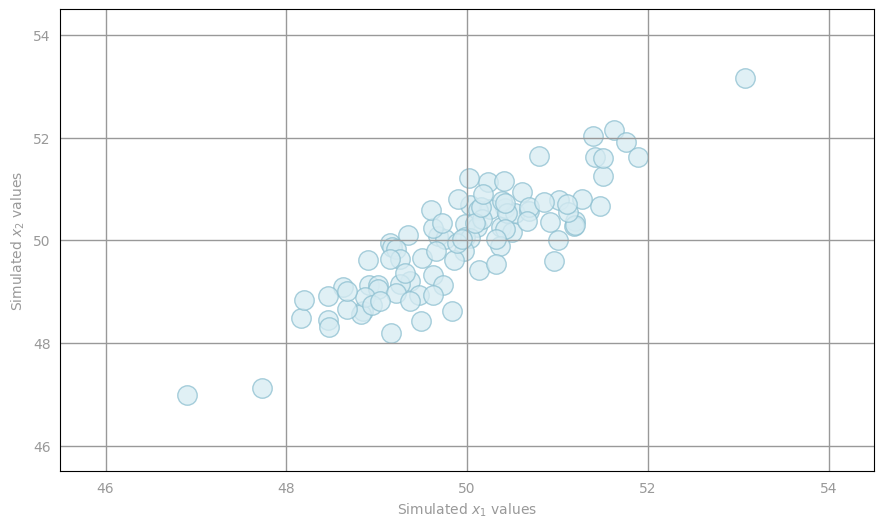

In [4]:
data_correlated = create_2D_gaussian(mn=50, variance=1, cov=.9, n=100)

# generate layout and plot data
fig, ax = prepare_plot(np.arange(46, 55, 2), np.arange(46, 55, 2))
ax.set_xlabel(r'Simulated $x_1$ values'), ax.set_ylabel(r'Simulated $x_2$ values')
ax.set_xlim(45.5, 54.5), ax.set_ylim(45.5, 54.5)
plt.scatter(data_correlated[:,0], data_correlated[:,1], s=14**2, c='#d6ebf2',
            edgecolors='#8cbfd0', alpha=0.75)
display(fig)

#(1a) Interpreting PCA
PCA can be interpreted as identifying the "directions" along which the data vary the most. In the first step of PCA, we must first center our data. Working with our correlated dataset, first compute the mean of each feature (column) in the dataset. Then for each observation, modify the features by subtracting their corresponding mean, to create a zero mean dataset.

Note:

correlated_data is an RDD of NumPy arrays.
This allows us to perform certain operations more succinctly.
For example, we can sum the columns of our dataset using correlated_data.sum().

In [8]:
from pyspark import SparkContext
sc = SparkContext("local", "SimpleApp")

# TODO: Replace <FILL IN> with appropriate code
correlated_data = sc.parallelize(data_correlated)

#mean_correlated = <FILL IN>
mean_correlated = correlated_data.mean()
#correlated_data_zero_mean = correlated_data.<FILL IN>
correlated_data_zero_mean = correlated_data.map(lambda x: x-mean_correlated)

print (mean_correlated)
print (correlated_data.take(1))
print (correlated_data_zero_mean.take(1))

[49.95739037 49.97180477]
[array([49.6717712 , 50.07531969])]
[array([-0.28561917,  0.10351492])]


#(1b) Sample covariance matrix
We are now ready to compute the sample covariance matrix. If we define
image.png
​​  as the zero mean data matrix, then the sample covariance matrix is defined as:
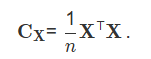

To compute this matrix, compute the outer product of each data point, add together these outer products, and divide by the number of data points. The data are two dimensional, so the resulting covariance matrix should be a 2x2 matrix.

Note:

np.outer() can be used to calculate the outer product of two NumPy arrays.

In [13]:
# TODO: Replace <FILL IN> with appropriate code
# Compute the covariance matrix using outer products and correlated_data_zero_mean
#correlated_cov = <FILL IN>
num_data_points = correlated_data_zero_mean.count()
print (num_data_points)
correlated_cov = correlated_data_zero_mean.map(lambda x: np.outer(x, x)).sum()/num_data_points
print (correlated_cov)

100
[[0.99558386 0.90148989]
 [0.90148989 1.08607497]]


#(1c) Covariance Function
Next, use the expressions above to write a function to compute the sample covariance matrix for an arbitrary data RDD.

In [15]:
# TODO: Replace <FILL IN> with appropriate code
def estimate_covariance(data):
    """Compute the covariance matrix for a given rdd.

    Note:
        The multi-dimensional covariance array should be calculated using outer products.  Don't
        forget to normalize the data by first subtracting the mean.

    Args:
        data (RDD of np.ndarray):  An `RDD` consisting of NumPy arrays.

    Returns:
        np.ndarray: A multi-dimensional array where the number of rows and columns both equal the
            length of the arrays in the input `RDD`.
    """
    #<FILL IN>
    data_mean = data.mean()
    corr_cov_data_mean_zero = data.map(lambda x: x-data_mean)
    num_data_pts = corr_cov_data_mean_zero.count()
    return corr_cov_data_mean_zero.map(lambda x: np.outer(x, x)).sum()/num_data_pts

correlated_cov_auto= estimate_covariance(correlated_data)
print (correlated_cov_auto)

[[0.99558386 0.90148989]
 [0.90148989 1.08607497]]


#(1d) Eigendecomposition
Now that we've computed the sample covariance matrix, we can use it to find directions of maximal variance in the data. Specifically, we can perform an eigendecomposition of this matrix to find its eigenvalues and eigenvectors. The
d
d eigenvectors of the covariance matrix give us the directions of maximal variance, and are often called the "principal components." The associated eigenvalues are the variances in these directions. In particular, the eigenvector corresponding to the largest eigenvalue is the direction of maximal variance (this is sometimes called the "top" eigenvector). Eigendecomposition of a
d
×
d
d×d covariance matrix has a (roughly) cubic runtime complexity with respect to
d
d. Whenever
d
d is relatively small (e.g., less than a few thousand) we can quickly perform this eigendecomposition locally.

Use a function from numpy.linalg called eigh to perform the eigendecomposition. Next, sort the eigenvectors based on their corresponding eigenvalues (from high to low), yielding a matrix where the columns are the eigenvectors (and the first column is the top eigenvector). Note that np.argsort can be used to obtain the indices of the eigenvalues that correspond to the ascending order of eigenvalues. Finally, set the top_component variable equal to the top eigenvector or prinicipal component, which is a
2
2-dimensional vector (array with two values).

Note:

The eigenvectors returned by eigh appear in the columns and not the rows.
For example, the first eigenvector of eig_vecs would be found in the first column and could be accessed using eig_vecs[:,0].

In [17]:
# TODO: Replace <FILL IN> with appropriate code
from numpy.linalg import eigh

# Calculate the eigenvalues and eigenvectors from correlated_cov_auto
#eig_vals, eig_vecs = <FILL IN>
eig_vals, eig_vecs = np.linalg.eigh(correlated_cov_auto)
print ('eigenvalues: {0}'.format(eig_vals))
print ('\neigenvectors: \n{0}'.format(eig_vecs))

# Use np.argsort to find the top eigenvector based on the largest eigenvalue
#inds = np.argsort(<FILL IN>)  numpy.argsort(a, axis=-1, kind='quicksort', order=None)
inds = np.argsort(eig_vals)[::-1]
#top_component = <FILL IN>
top_component = eig_vecs[:, inds[0]]
print ('\ntop principal component: {0}'.format(top_component))

eigenvalues: [0.13820481 1.94345403]

eigenvectors: 
[[-0.72461254  0.68915649]
 [ 0.68915649  0.72461254]]

top principal component: [0.68915649 0.72461254]


#(1e) PCA scores
We just computed the top principal component for a 2-dimensional non-spherical dataset. Now let's use this principal component to derive a one-dimensional representation for the original data. To compute these compact representations, which are sometimes called PCA "scores", calculate the dot product between each data point in the raw data and the top principal component.

In [18]:
# TODO: Replace <FILL IN> with appropriate code
# Use the top_component and the data from correlated_data to generate PCA scores
#correlated_data_scores = <FILL IN>
correlated_data_scores = correlated_data.map(lambda x: np.dot(x, top_component))
print ('one-dimensional data (first three):\n{0}'.format(np.asarray(correlated_data_scores.take(3))))

one-dimensional data (first three):
[70.51682806 69.30622356 71.13588168]


#Part 2: Write a PCA function and evaluate PCA on sample datasets
#(2a) PCA function
We now have all the ingredients to write a general PCA function. Instead of working with just the top principal component, our function will compute the top
k
k principal components and principal scores for a given dataset. The top
k
k principal components should be returned in descending order when ranked by their corresponding principal scores. Write this general function pca, and run it with correlated_data and
k
=
2
k=2. Hint: Use results from Part (1c), Part (1d), and Part (1e).

Note: As discussed in lecture, our implementation is a reasonable strategy when
d
d is small, though more efficient distributed algorithms exist when
d
d is large.

In [20]:
# TODO: Replace <FILL IN> with appropriate code
def pca(data, k=2):
    """Computes the top `k` principal components, corresponding scores, and all eigenvalues.

    Note:
        All eigenvalues should be returned in sorted order (largest to smallest). `eigh` returns
        each eigenvectors as a column.  This function should also return eigenvectors as columns.

    Args:
        data (RDD of np.ndarray): An `RDD` consisting of NumPy arrays.
        k (int): The number of principal components to return.

    Returns:
        tuple of (np.ndarray, RDD of np.ndarray, np.ndarray): A tuple of (eigenvectors, `RDD` of
            scores, eigenvalues).  Eigenvectors is a multi-dimensional array where the number of
            rows equals the length of the arrays in the input `RDD` and the number of columns equals
            `k`.  The `RDD` of scores has the same number of rows as `data` and consists of arrays
            of length `k`.  Eigenvalues is an array of length d (the number of features).
    """
    #<FILL IN>
    correlated_cov_auto = estimate_covariance(data)
    eig_vals, eig_vecs = np.linalg.eigh(correlated_cov_auto)
    inds = np.argsort(eig_vals)[::-1]
    top_k_components = eig_vecs[:, inds[:k]] # size (len(array), k)
    correlated_data_scores = data.map(lambda x: np.dot(x, top_k_components))

    # Return the `k` principal components, `k` scores, and all eigenvalues
    #<FILL IN>
    return (top_k_components, correlated_data_scores, eig_vals[::-1])

# Run pca on correlated_data with k = 2
#top_components_correlated, correlated_data_scores_auto, eigenvalues_correlated = <FILL IN>
top_components_correlated, correlated_data_scores_auto, eigenvalues_correlated = pca(correlated_data, k=2)

# Note that the 1st principal component is in the first column
print ('top_components_correlated: \n{0}'.format(top_components_correlated))
print ('\ncorrelated_data_scores_auto (first three): \n{0}'
       .format('\n'.join(map(str, correlated_data_scores_auto.take(3)))))
print ('\neigenvalues_correlated: \n{0}'.format(eigenvalues_correlated))

# Create a higher dimensional test set
pca_test_data = sc.parallelize([np.arange(x, x + 4) for x in np.arange(0, 20, 4)])
components_test, test_scores, eigenvalues_test = pca(pca_test_data, 3)

print ('\npca_test_data: \n{0}'.format(np.array(pca_test_data.collect())))
print ('\ncomponents_test: \n{0}'.format(components_test))
print('\ntest_scores (first three): \n{0}'
       .format('\n'.join(map(str, test_scores.take(3)))))
print ('\neigenvalues_test: \n{0}'.format(eigenvalues_test))

top_components_correlated: 
[[ 0.68915649 -0.72461254]
 [ 0.72461254  0.68915649]]

correlated_data_scores_auto (first three): 
[70.51682806 -1.48305648]
[69.30622356 -1.5888655 ]
[71.13588168 -1.86710679]

eigenvalues_correlated: 
[1.94345403 0.13820481]

pca_test_data: 
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]
 [16 17 18 19]]

components_test: 
[[ 5.00000000e-01 -7.41676339e-18 -3.43150291e-01]
 [ 5.00000000e-01 -2.25877598e-16 -6.35281904e-01]
 [ 5.00000000e-01 -7.07106781e-01  4.89216098e-01]
 [ 5.00000000e-01  7.07106781e-01  4.89216098e-01]]

test_scores (first three): 
[3.         0.70710678 1.81079858]
[11.          0.70710678  1.81079858]
[19.          0.70710678  1.81079858]

eigenvalues_test: 
[ 1.28000000e+02 -3.94430453e-31 -1.09584308e-14 -3.16741334e-14]


#(2b) PCA on data_random
Next, use the PCA function we just developed to find the top two principal components of the spherical data_random we created in Visualization 1.

First, we need to convert data_random to the RDD random_data_rdd, and do all subsequent operations on random_data_rdd.

In [21]:
# TODO: Replace <FILL IN> with appropriate code
random_data_rdd = sc.parallelize(data_random)

# Use pca on data_random
#top_components_random, random_data_scores_auto, eigenvalues_random = <FILL IN>
top_components_random, random_data_scores_auto, eigenvalues_random = pca(random_data_rdd, k=2)
print ('top_components_random: \n{0}'.format(top_components_random))
print ('\nrandom_data_scores_auto (first three): \n{0}'
       .format('\n'.join(map(str, random_data_scores_auto.take(3)))))
print ('\neigenvalues_random: \n{0}'.format(eigenvalues_random))

top_components_random: 
[[-0.2522559  -0.96766056]
 [ 0.96766056 -0.2522559 ]]

random_data_scores_auto (first three): 
[ 36.61068572 -61.3489929 ]
[ 35.97314295 -62.08813671]
[ 35.59836628 -60.61390415]

eigenvalues_random: 
[1.4204546  0.99521397]


#Visualization 2: PCA projection
Plot the original data and the 1-dimensional reconstruction using the top principal component to see how the PCA solution looks. The original data is plotted as before; however, the 1-dimensional reconstruction (projection) is plotted in green on top of the original data and the vectors (lines) representing the two principal components are shown as dotted lines.

In [22]:
def project_points_and_get_lines(data, components, x_range):
    """Project original data onto first component and get line details for top two components."""
    top_component = components[:, 0]
    slope1, slope2 = components[1, :2] / components[0, :2]

    means = data.mean()[:2]
    demeaned = data.map(lambda v: v - means)
    projected = demeaned.map(lambda v: (v.dot(top_component) /
                                        top_component.dot(top_component)) * top_component)
    remeaned = projected.map(lambda v: v + means)
    x1,x2 = zip(*remeaned.collect())

    line_start_P1_X1, line_start_P1_X2 = means - np.asarray([x_range, x_range * slope1])
    line_end_P1_X1, line_end_P1_X2 = means + np.asarray([x_range, x_range * slope1])
    line_start_P2_X1, line_start_P2_X2 = means - np.asarray([x_range, x_range * slope2])
    line_end_P2_X1, line_end_P2_X2 = means + np.asarray([x_range, x_range * slope2])

    return ((x1, x2), ([line_start_P1_X1, line_end_P1_X1], [line_start_P1_X2, line_end_P1_X2]),
            ([line_start_P2_X1, line_end_P2_X1], [line_start_P2_X2, line_end_P2_X2]))

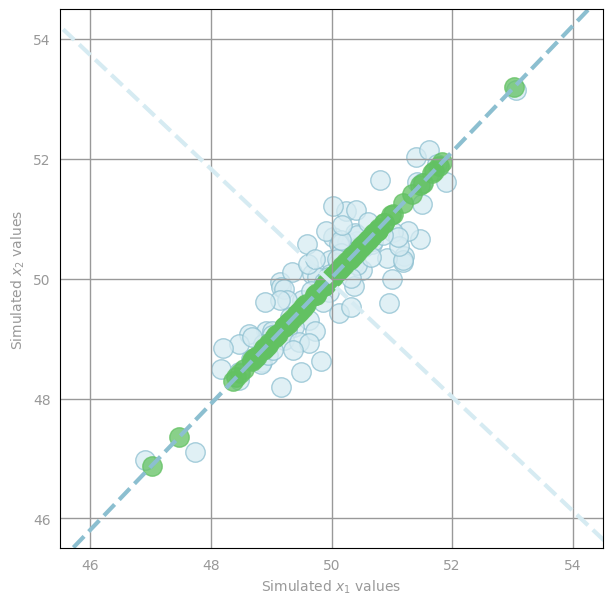

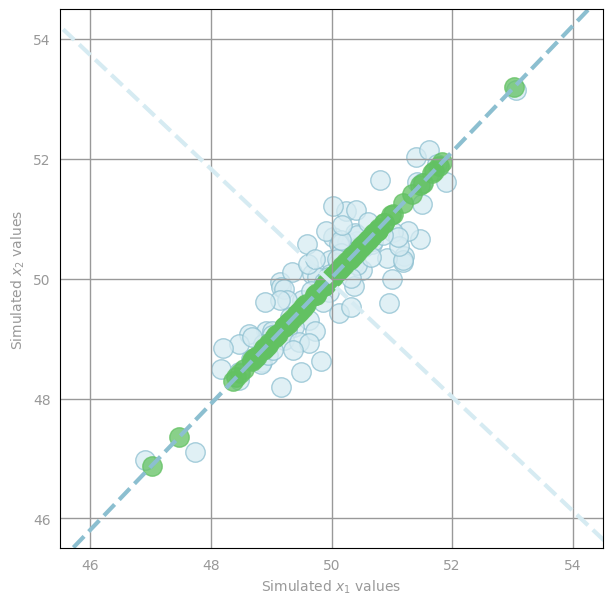

In [23]:
((x1, x2), (line1X1, line1X2), (line2X1, line2X2)) = \
    project_points_and_get_lines(correlated_data, top_components_correlated, 5)

# generate layout and plot data
fig, ax = prepare_plot(np.arange(46, 55, 2), np.arange(46, 55, 2), figsize=(7, 7))
ax.set_xlabel(r'Simulated $x_1$ values'), ax.set_ylabel(r'Simulated $x_2$ values')
ax.set_xlim(45.5, 54.5), ax.set_ylim(45.5, 54.5)
plt.plot(line1X1, line1X2, linewidth=3.0, c='#8cbfd0', linestyle='--')
plt.plot(line2X1, line2X2, linewidth=3.0, c='#d6ebf2', linestyle='--')
plt.scatter(data_correlated[:,0], data_correlated[:,1], s=14**2, c='#d6ebf2',
            edgecolors='#8cbfd0', alpha=0.75)
plt.scatter(x1, x2, s=14**2, c='#62c162', alpha=.75)
display(fig)

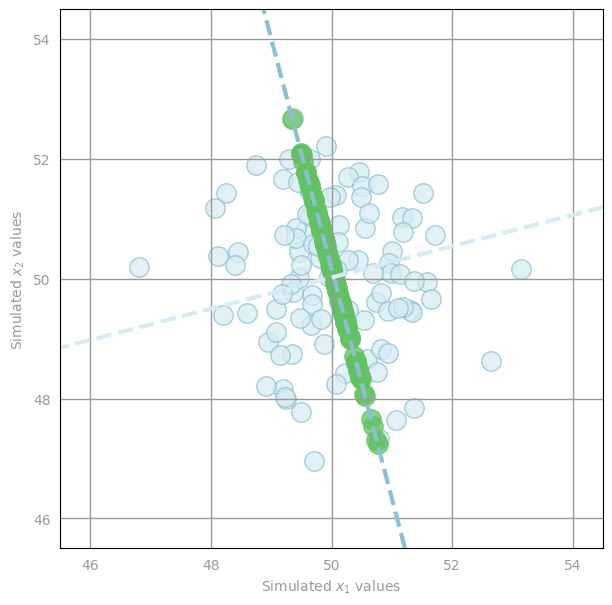

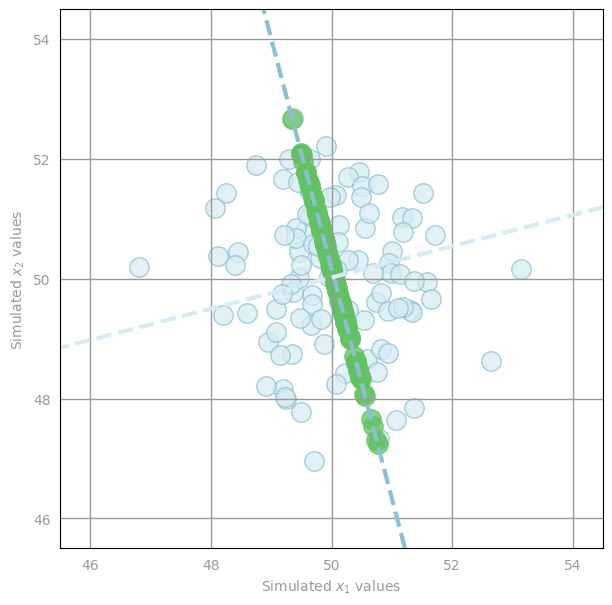

In [24]:
((x1, x2), (line1X1, line1X2), (line2X1, line2X2)) = \
    project_points_and_get_lines(random_data_rdd, top_components_random, 5)

# generate layout and plot data
fig, ax = prepare_plot(np.arange(46, 55, 2), np.arange(46, 55, 2), figsize=(7, 7))
ax.set_xlabel(r'Simulated $x_1$ values'), ax.set_ylabel(r'Simulated $x_2$ values')
ax.set_xlim(45.5, 54.5), ax.set_ylim(45.5, 54.5)
plt.plot(line1X1, line1X2, linewidth=3.0, c='#8cbfd0', linestyle='--')
plt.plot(line2X1, line2X2, linewidth=3.0, c='#d6ebf2', linestyle='--')
plt.scatter(data_random[:,0], data_random[:,1], s=14**2, c='#d6ebf2',
            edgecolors='#8cbfd0', alpha=0.75)
plt.scatter(x1, x2, s=14**2, c='#62c162', alpha=.75)
display(fig)

#Visualization 3: Three-dimensional data
So far we have worked with two-dimensional data. Now let's generate three-dimensional data with highly correlated features. As in Visualization 1, we'll create samples from a multivariate Gaussian distribution, which in three dimensions requires us to specify three means, three variances, and three covariances.

In the 3D graphs below, we have included the 2D plane that corresponds to the top two principal components, i.e. the plane with the smallest euclidean distance between the points and itself. Notice that the data points, despite living in three-dimensions, are found near a two-dimensional plane: the left graph shows how most points are close to the plane when it is viewed from its side, while the right graph shows that the plane covers most of the variance in the data. Note that darker blues correspond to points with higher values for the third dimension.

<ipython-input-25-061f0f44031c>:15: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data_threeD = np.random.multivariate_normal(mu, c, m)
<ipython-input-25-061f0f44031c>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("Blues")


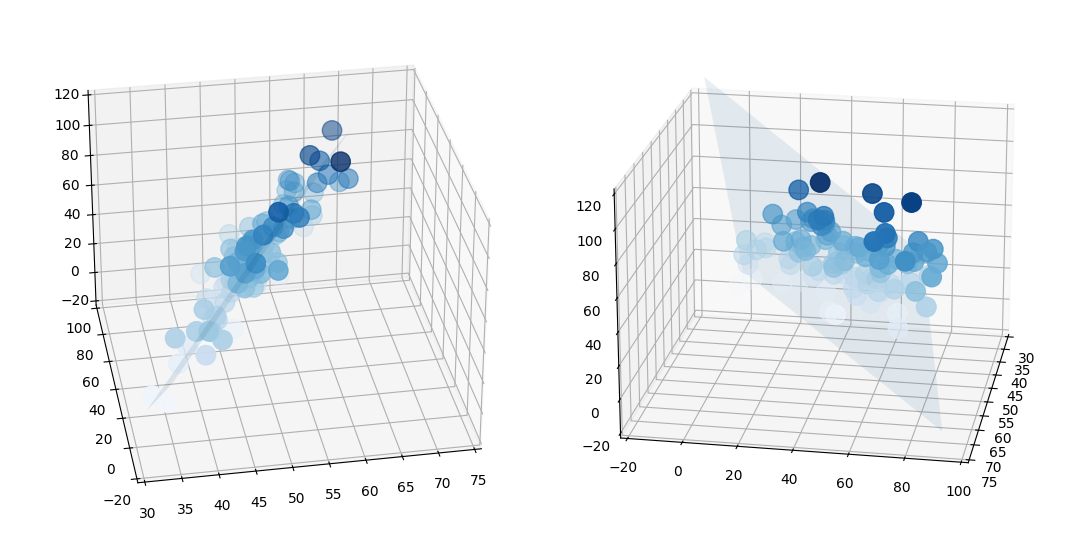

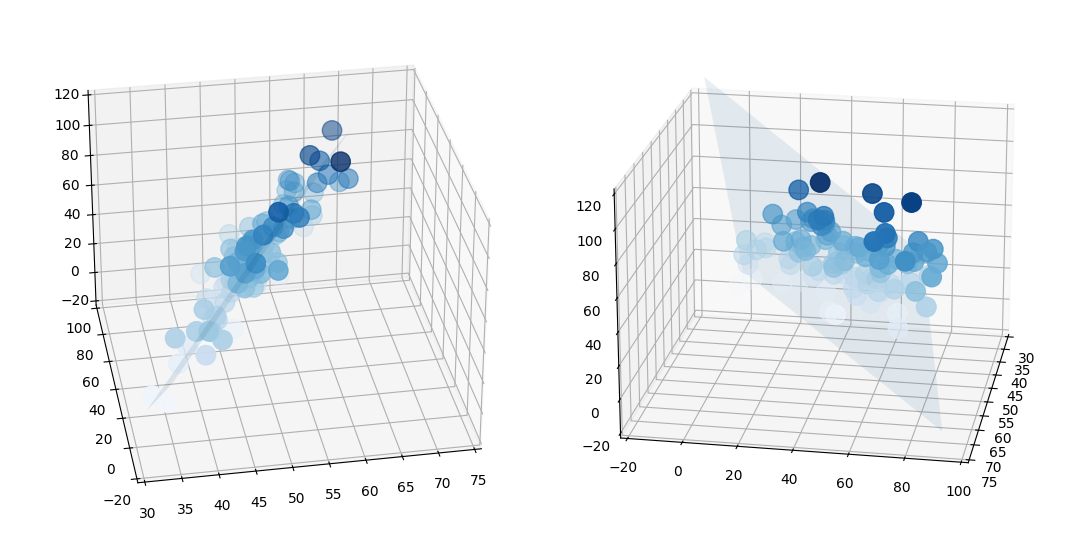

In [25]:
from mpl_toolkits.mplot3d import Axes3D

m = 100
mu = np.array([50, 50, 50])
r1_2 = 0.9
r1_3 = 0.7
r2_3 = 0.1
sigma1 = 5
sigma2 = 20
sigma3 = 20
c = np.array([[sigma1 ** 2, r1_2 * sigma1 * sigma2, r1_3 * sigma1 * sigma3],
             [r1_2 * sigma1 * sigma2, sigma2 ** 2, r2_3 * sigma2 * sigma3],
             [r1_3 * sigma1 * sigma3, r2_3 * sigma2 * sigma3, sigma3 ** 2]])
np.random.seed(142)
data_threeD = np.random.multivariate_normal(mu, c, m)

from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap
norm = Normalize()
cmap = get_cmap("Blues")
clrs = cmap(np.array(norm(data_threeD[:,2])))[:,0:3]

fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(121, projection='3d')
ax.azim=-100
ax.scatter(data_threeD[:,0], data_threeD[:,1], data_threeD[:,2], c=clrs, s=14**2)

xx, yy = np.meshgrid(np.arange(-15, 10, 1), np.arange(-50, 30, 1))
normal = np.array([0.96981815, -0.188338, -0.15485978])
z = (-normal[0] * xx - normal[1] * yy) * 1. / normal[2]
xx = xx + 50
yy = yy + 50
z = z + 50

ax.set_zlim((-20, 120)), ax.set_ylim((-20, 100)), ax.set_xlim((30, 75))
ax.plot_surface(xx, yy, z, alpha=.10)

ax = fig.add_subplot(122, projection='3d')
ax.azim=10
ax.elev=20
#ax.dist=8
ax.scatter(data_threeD[:,0], data_threeD[:,1], data_threeD[:,2], c=clrs, s=14**2)

ax.set_zlim((-20, 120)), ax.set_ylim((-20, 100)), ax.set_xlim((30, 75))
ax.plot_surface(xx, yy, z, alpha=.1)
plt.tight_layout()
display(fig)

#(2c) 3D to 2D
We will now use PCA to see if we can recover the 2-dimensional plane on which the data live. Parallelize the data, and use our PCA function from above, with
k
=
2
k=2 components.



In [26]:
threeD_data = sc.parallelize(data_threeD)
#components_threeD, threeD_scores, eigenvalues_threeD = <FILL IN>
components_threeD, threeD_scores, eigenvalues_threeD = pca(threeD_data, 2)

print ('components_threeD: \n{0}'.format(components_threeD))
print ('\nthreeD_scores (first three): \n{0}'
       .format('\n'.join(map(str, threeD_scores.take(3)))))
print ('\neigenvalues_threeD: \n{0}'.format(eigenvalues_threeD))

components_threeD: 
[[ 0.23952078  0.045635  ]
 [ 0.61699931  0.76409466]
 [ 0.74962768 -0.64348799]]

threeD_scores (first three): 
[85.25798606 -8.29694407]
[89.66337911 15.73381517]
[ 75.92616872 -20.5015709 ]

eigenvalues_threeD: 
[614.46863537 349.47737219   5.85043581]


#Visualization 4: 2D representation of 3D data
See the 2D version of the data that captures most of its original structure. Note that darker blues correspond to points with higher values for the original data's third dimension.

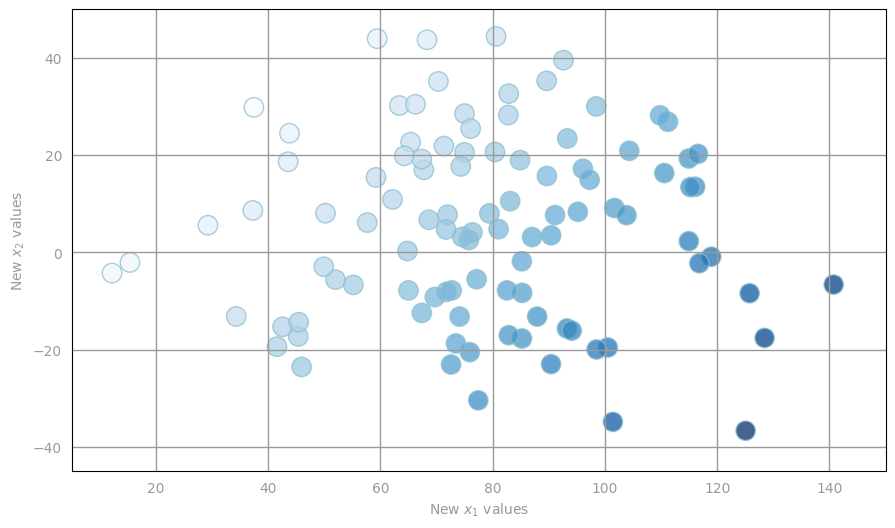

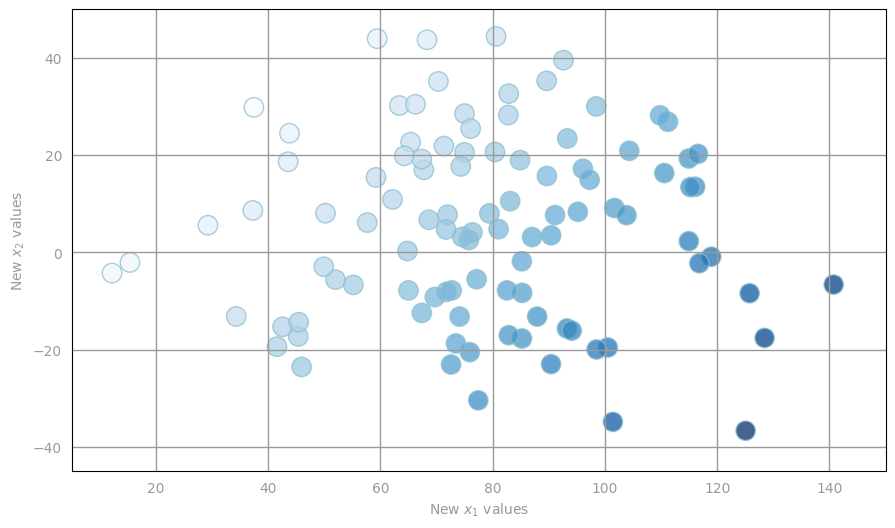

In [27]:
scores_threeD = np.asarray(threeD_scores.collect())

# generate layout and plot data
fig, ax = prepare_plot(np.arange(20, 150, 20), np.arange(-40, 110, 20))
ax.set_xlabel(r'New $x_1$ values'), ax.set_ylabel(r'New $x_2$ values')
ax.set_xlim(5, 150), ax.set_ylim(-45, 50)
plt.scatter(scores_threeD[:, 0], scores_threeD[:, 1], s=14 ** 2, c=clrs, edgecolors='#8cbfd0', alpha=0.75)
display(fig)

#(2d) Variance explained
Finally, let's quantify how much of the variance is being captured by PCA in each of the three synthetic datasets we've analyzed. To do this, we'll compute the fraction of retained variance by the top principal components. Recall that the eigenvalue corresponding to each principal component captures the variance along this direction. If our initial data is
d
d-dimensional, then the total variance in our data equals:
∑
i
=
1
d
λ
i
∑
​i=1
​d
​​ λ
​i
​​ , where
λ
i
λ
​i
​​  is the eigenvalue corresponding to the
i
ith principal component. Moreover, if we use PCA with some
k
<
d
k<d, then we can compute the variance retained by these principal components by adding the top
k
k eigenvalues. The fraction of retained variance equals the sum of the top
k
k eigenvalues divided by the sum of all of the eigenvalues.

In [28]:
# TODO: Replace <FILL IN> with appropriate code
def variance_explained(data, k=1):
    """Calculate the fraction of variance explained by the top `k` eigenvectors.

    Args:
        data (RDD of np.ndarray): An RDD that contains NumPy arrays which store the
            features for an observation.
        k: The number of principal components to consider.

    Returns:
        float: A number between 0 and 1 representing the percentage of variance explained
            by the top `k` eigenvectors.
    """
    #components, scores, eigenvalues = <FILL IN>
    components, scores, eigenvalues = pca(data, k)
    #<FILL IN>  # retained variance is the sum of the top k eigenvalues divided by the sum of all of the eigenvalues
    retained_variance =  sum(eigenvalues[:k])/(np.sum(eigenvalues))
    return retained_variance

variance_random_1 = variance_explained(random_data_rdd, 1)
variance_correlated_1 = variance_explained(correlated_data, 1)
variance_random_2 = variance_explained(random_data_rdd, 2)
variance_correlated_2 = variance_explained(correlated_data, 2)
variance_threeD_2 = variance_explained(threeD_data, 2)
print ('Percentage of variance explained by the first component of random_data_rdd: {0:.1f}%'
       .format(variance_random_1 * 100))
print ('Percentage of variance explained by both components of random_data_rdd: {0:.1f}%'
       .format(variance_random_2 * 100))
print ('\nPercentage of variance explained by the first component of correlated_data: {0:.1f}%'.
       format(variance_correlated_1 * 100))
print ('Percentage of variance explained by both components of correlated_data: {0:.1f}%'
       .format(variance_correlated_2 * 100))
print ('\nPercentage of variance explained by the first two components of threeD_data: {0:.1f}%'
       .format(variance_threeD_2 * 100))

Percentage of variance explained by the first component of random_data_rdd: 58.8%
Percentage of variance explained by both components of random_data_rdd: 100.0%

Percentage of variance explained by the first component of correlated_data: 93.4%
Percentage of variance explained by both components of correlated_data: 100.0%

Percentage of variance explained by the first two components of threeD_data: 99.4%


#Part 3: Parse, inspect, and preprocess neuroscience data then perform PCA
#Data introduction
A central challenge in neuroscience is understanding the organization and function of neurons, the cells responsible for processing and representing information in the brain. New technologies make it possible to monitor the responses of large populations of neurons in awake animals. In general, neurons communicate through electrical impulses that must be recorded with electrodes, which is a challenging process. As an alternative, we can genetically engineer animals so that their neurons express special proteins that fluoresce or light up when active, and then use microscopy to record neural activity as images.

A recently developed method called light-sheet microscopy lets us do this in a special, transparent animal, the larval zebrafish, over nearly its entire brain. The resulting data are time-varying images containing the activity of hundreds of thousands of neurons. Given the raw data, which is enormous, we want to find compact spatial and temporal patterns: Which groups of neurons are active together? What is the time course of their activity? Are those patterns specific to particular events happening during the experiment (e.g. a stimulus that we might present). PCA is a powerful technique for finding spatial and temporal patterns in these kinds of data, and that's what we'll explore here!
#(3a) Load neuroscience data
In the next sections we will use PCA to capture structure in neural datasets. Before doing the analysis, we will load and do some basic inspection of the data. The raw data are currently stored as a text file. Every line in the file contains the time series of image intensity for a single pixel in a time-varying image (i.e. a movie). The first two numbers in each line are the spatial coordinates of the pixel, and the remaining numbers are the time series. We'll use first() to inspect a single row, and print just the first 100 characters.

In [31]:
import os
input_file = os.path.join('databricks-datasets', 'cs190', 'data-001', 'neuro.txt')

lines = sc.textFile(input_file)
print (lines.first()[0:100])

# Check that everything loaded properly
assert len(lines.first()) == 1397
assert lines.count() == 46460

Py4JJavaError: An error occurred while calling o492.partitions.
: org.apache.hadoop.mapred.InvalidInputException: Input path does not exist: file:/content/databricks-datasets/cs190/data-001/neuro.txt
	at org.apache.hadoop.mapred.FileInputFormat.singleThreadedListStatus(FileInputFormat.java:304)
	at org.apache.hadoop.mapred.FileInputFormat.listStatus(FileInputFormat.java:244)
	at org.apache.hadoop.mapred.FileInputFormat.getSplits(FileInputFormat.java:332)
	at org.apache.spark.rdd.HadoopRDD.getPartitions(HadoopRDD.scala:208)
	at org.apache.spark.rdd.RDD.$anonfun$partitions$2(RDD.scala:294)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:290)
	at org.apache.spark.rdd.MapPartitionsRDD.getPartitions(MapPartitionsRDD.scala:49)
	at org.apache.spark.rdd.RDD.$anonfun$partitions$2(RDD.scala:294)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:290)
	at org.apache.spark.api.java.JavaRDDLike.partitions(JavaRDDLike.scala:61)
	at org.apache.spark.api.java.JavaRDDLike.partitions$(JavaRDDLike.scala:61)
	at org.apache.spark.api.java.AbstractJavaRDDLike.partitions(JavaRDDLike.scala:45)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.io.IOException: Input path does not exist: file:/content/databricks-datasets/cs190/data-001/neuro.txt
	at org.apache.hadoop.mapred.FileInputFormat.singleThreadedListStatus(FileInputFormat.java:278)
	... 25 more


In [32]:
example = raw_data.filter(lambda (k, v): np.std(v) > 100).values().first()

# generate layout and plot data
fig, ax = prepare_plot(np.arange(0, 300, 50), np.arange(300, 800, 100))
ax.set_xlabel(r'time'), ax.set_ylabel(r'fluorescence')
ax.set_xlim(-20, 270), ax.set_ylim(270, 730)
plt.plot(range(len(example)), example, c='#8cbfd0', linewidth='3.0')
display(fig)

SyntaxError: invalid syntax (<ipython-input-32-d9e092a12d9f>, line 1)